# Hand-held object Detection

#### 1. Environment Setup for yolov5 (Skip if performing inference only)

In [22]:
# !git clone https://github.com/ultralytics/yolov5  # clone
# %cd yolov5
# %pip install -qr requirements.txt  # install

In [23]:
# %cd yolov5
# import utils
# display = utils.notebook_init()  # checks

In [24]:
# Change directory back to hand_object_detection
# %cd ..

---------

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import torch
import os
import pandas as pd
import numpy as np

from pathlib import Path
from matplotlib import pyplot as plt
from IPython.display import HTML, Image, display as ip_display


from custom_utils import get_image_path_from_folder, hand_grasp_object_mark

In [27]:
#main dir path
ROOT = str(Path.cwd())
ROOT

'/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition'

### 2. Building the dataset

- Link to dataset curated, https://app.roboflow.com/dsprojects-1ey6h/hand-object-grasp/6
    - Training: 620
    - Valid: 68
    - Test: 62

- Test set will be available for inference at datasets/hand_object_grasp_v6/test/ (62 images)

In [28]:
sample_img_path = ROOT + '/datasets/hand_object_grasp_v6/test/images'
sample_path_list = os.listdir(sample_img_path)[:10]

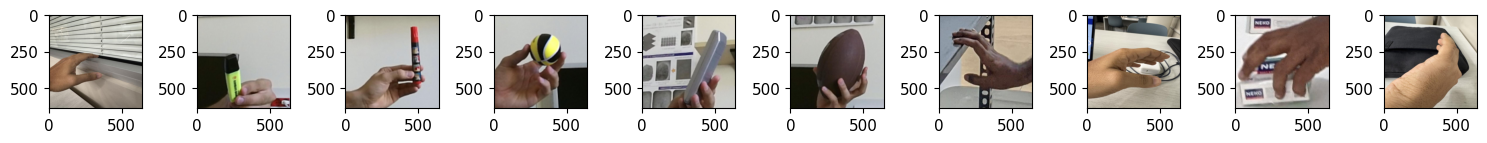

In [29]:
# Data Samples
%matplotlib inline

fig, ax = plt.subplots(1, len(sample_path_list), figsize=(15,5))

for i in range(len(sample_path_list)):
    img_data = plt.imread(sample_img_path + '/' + sample_path_list[i])
    ax[i].imshow(img_data)

plt.tight_layout()
plt.show()

## 3. Training yolov5 for hand and object detections

- Run command for reference. The same was run on terminal and latest epoch wise results will be saved here: yolov5/runs/train/exp12/results.csv
- The performance metrics of the model are at the end of the notebook

In [30]:
# %cd yolov5
# !python train.py --img 640 --batch-size 16 --epochs 40 --data HandObject.yaml --weights yolov5s.pt --device cpu
# %cd ..

**Parameters**

- img: dimension of training image (images resized and trained with size 640X640)
- batch-size: no. of images considered at once and model weights are updated
- epochs: no. of times the model goes through complete dataset
- data: a data config file (by creating one under yolov5/data. Define train, test dataset path and also the target classes)
- weights: name of the pretrained model
- device: cpu/gpu

Note: 
- A successful run will store best and last model, followed by performance charts under the directory, "*yolov5/runs/train/exp12/*"  (here exp12 refers to the 12th train run in my case).
- All of these are moved to *yolov5_resources* dir for easy access

## 3.1 Load the model

- Model is yolov5s (small) fine tuned over custom dataset (as shown in step #3)
- It's lightweight and suitable for low computing edge device deployments

In [31]:
# model path 
model_path = 'yolov5_resources/exp12/weights/best.pt'

In [32]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

Using cache found in /Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-22 Python-3.10.16 torch-2.6.0 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


## 4. Get hand and object detections 

1. A yolov5 model fine tuned with custom dataset returns hand and object detections with confidence metrics
2. Utilizing confidence metrics and iou scores to classify the image as 'hand grasp object' or 'no grasp'

In [33]:
#define relevant paths

#test image dir 
test_img_folder = 'datasets/hand_object_grasp_v6/test/images/'

#get all image paths from given folder
test_image_paths = get_image_path_from_folder(test_img_folder)

About classifier logic:
- Marking images as 'hand grasp object' where the IoU (intersection over union) is >0.1 else 'no grasp'
- Intersection over union (IoU): Gives the intersection value of bounding boxes of both hand and object (only if both exists and detected) over the total area. This metric helps to differentiate whether a hand holds any object or not

In [34]:
# run model over test images

save_result_path = ROOT + '/results'
print(save_result_path)

result_list = []
for img_path in test_image_paths:
    result = model(img_path)
    detections = result.xyxy[0].numpy()

    hand_interactions = hand_grasp_object_mark(result, detections, save_result_path)
    result_list.extend(hand_interactions)

result_df = pd.DataFrame(result_list)
result_df.index = result_df.index+1

/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users

/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18
/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to /Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


/Users/pradyumnakumar/Documents/masters/ksu/projects/handheld-recognition/results/detections_2025-08-20_02-18


## 5. Visualise results

In [35]:
# convert links to html tags
def path_to_image_html(path):
    return '<img src="' + os.path.join(test_img_folder, path) + '" width="180" >'

In [36]:
format_dict = {}
image_cols = ['img_name']
result_path = 'results/hand_grasp_result.html'

pd.set_option('display.max_colwidth', None)

for image_col in image_cols:
    format_dict[image_col] = path_to_image_html

result_df.to_html(result_path, escape=False ,formatters=format_dict)

In [37]:
ip_display(HTML(result_path))

,img_name,hand_confidence,object_confidence,iou_score,result (iou > 0.01)
1,,0.644467,0.000000,0.000000,no grasp
2,,0.603039,0.727367,0.182930,hand grasp object
3,,0.650852,0.478500,0.046898,hand grasp object
4,,0.818667,0.836622,0.185530,hand grasp object
5,,0.393249,0.338336,0.201202,hand grasp object
6,,0.786313,0.000000,0.000000,no grasp
7,,0.460044,0.000000,0.000000,no grasp
8,,0.312762,0.303649,0.034130,hand grasp object
9,,0.543198,0.000000,0.000000,no grasp
10,,0.372880,0.000000,0.000000,no grasp


- Out of 62 test images, 13 were wrongly detected by the model. Either missing to detect hand or object.
- Confidence with 0.0 score means there was no detection of that class according to the model

## 6. Results and Discussion

- Model performance visualizations (label distribution, confusion matrix, training curves) are included below.  

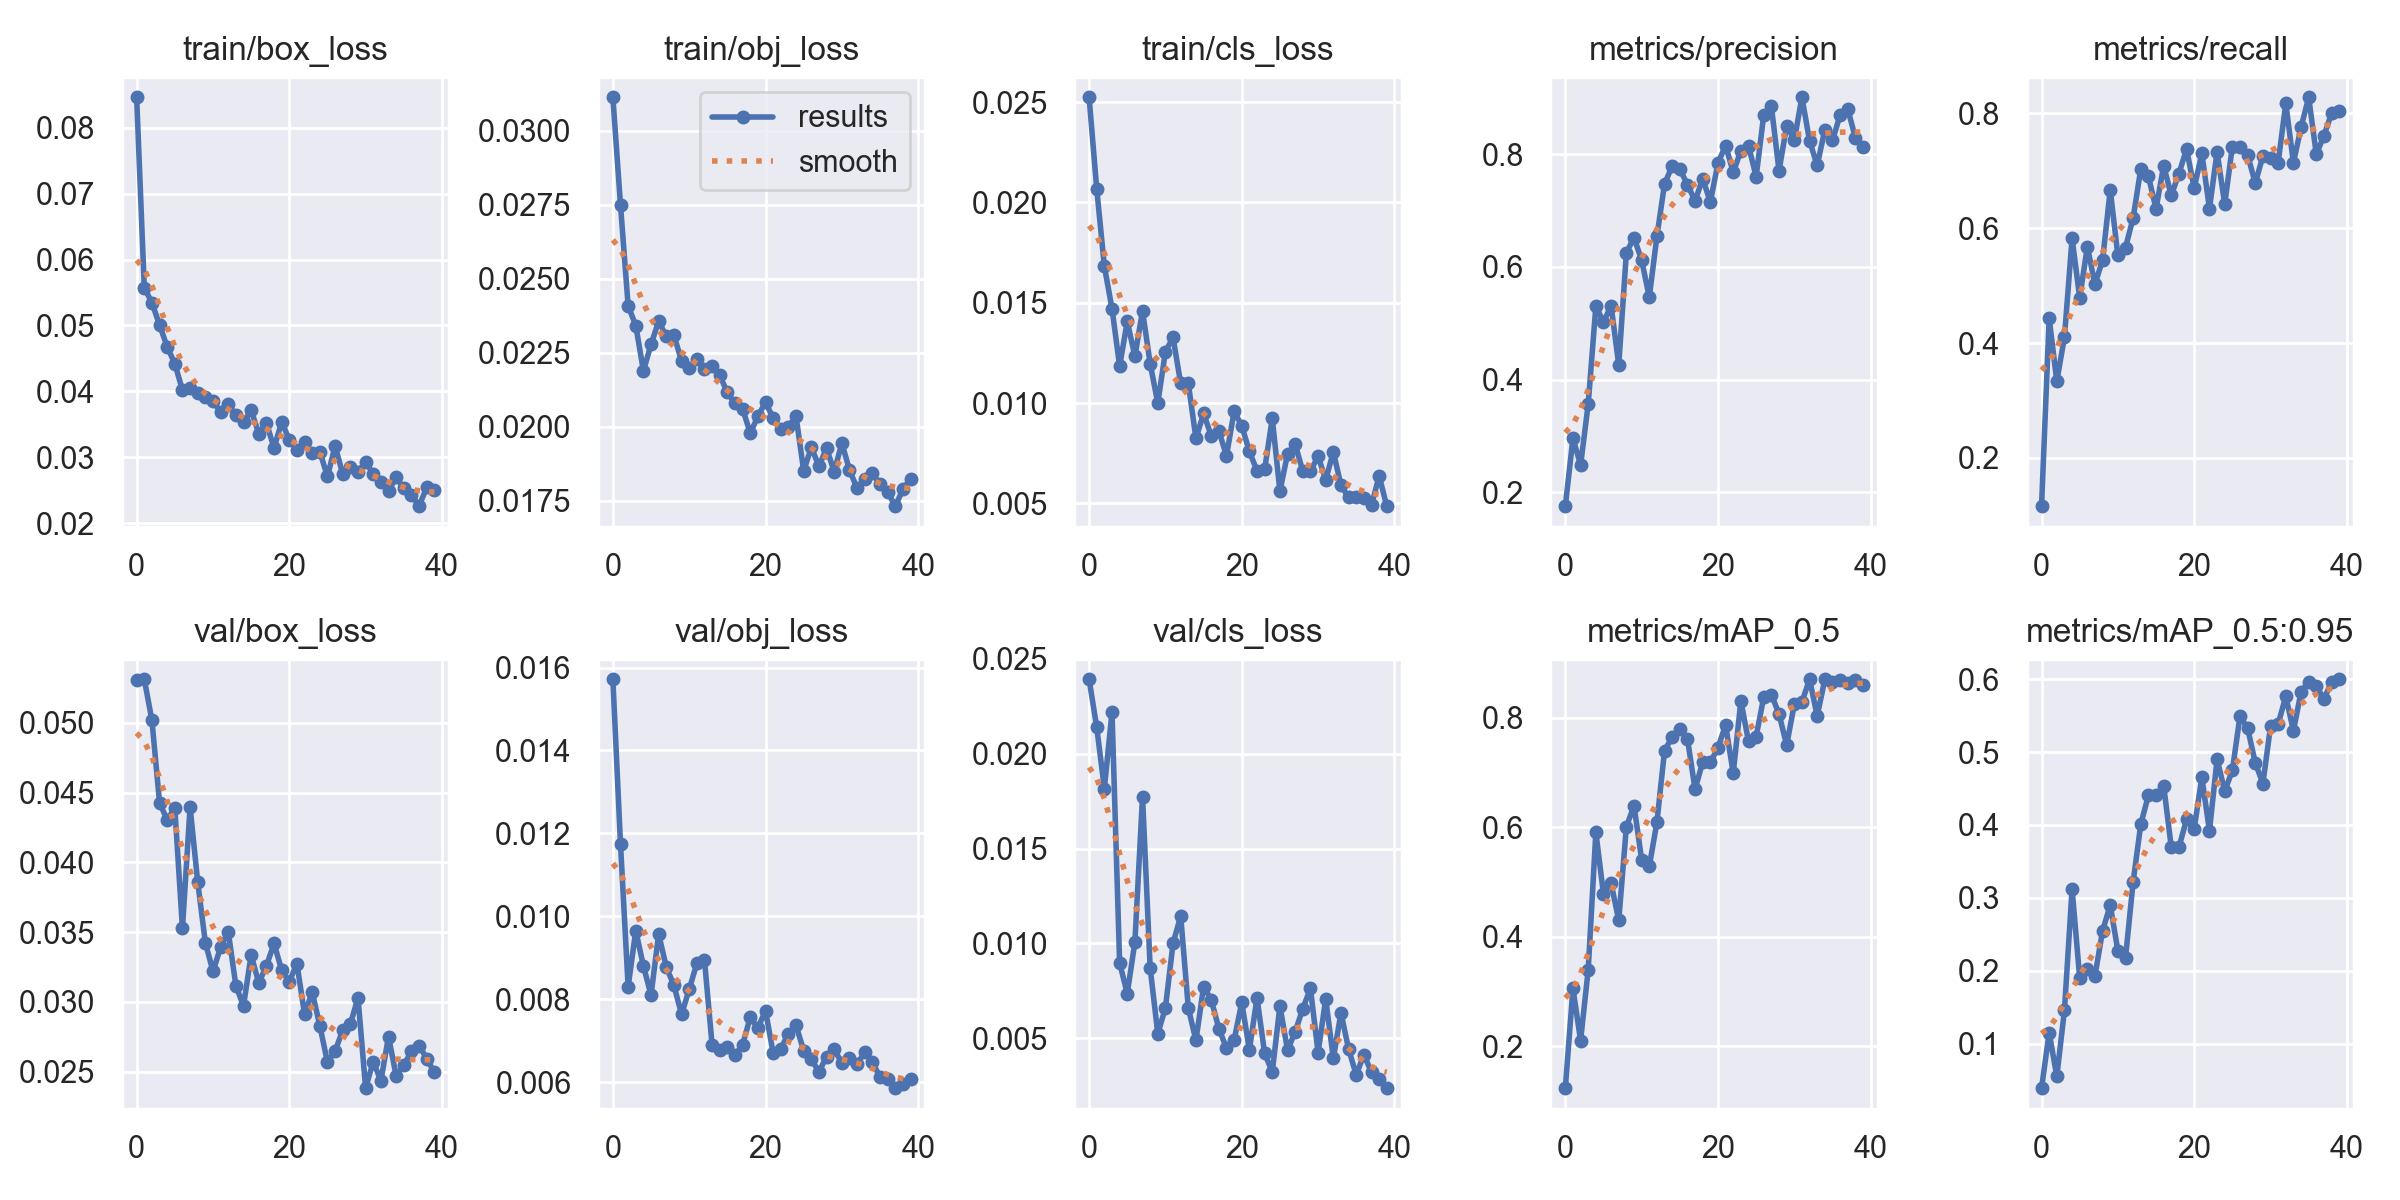

In [38]:
ip_display(Image(filename= ROOT + '/yolov5_resources/exp12/results.png'))

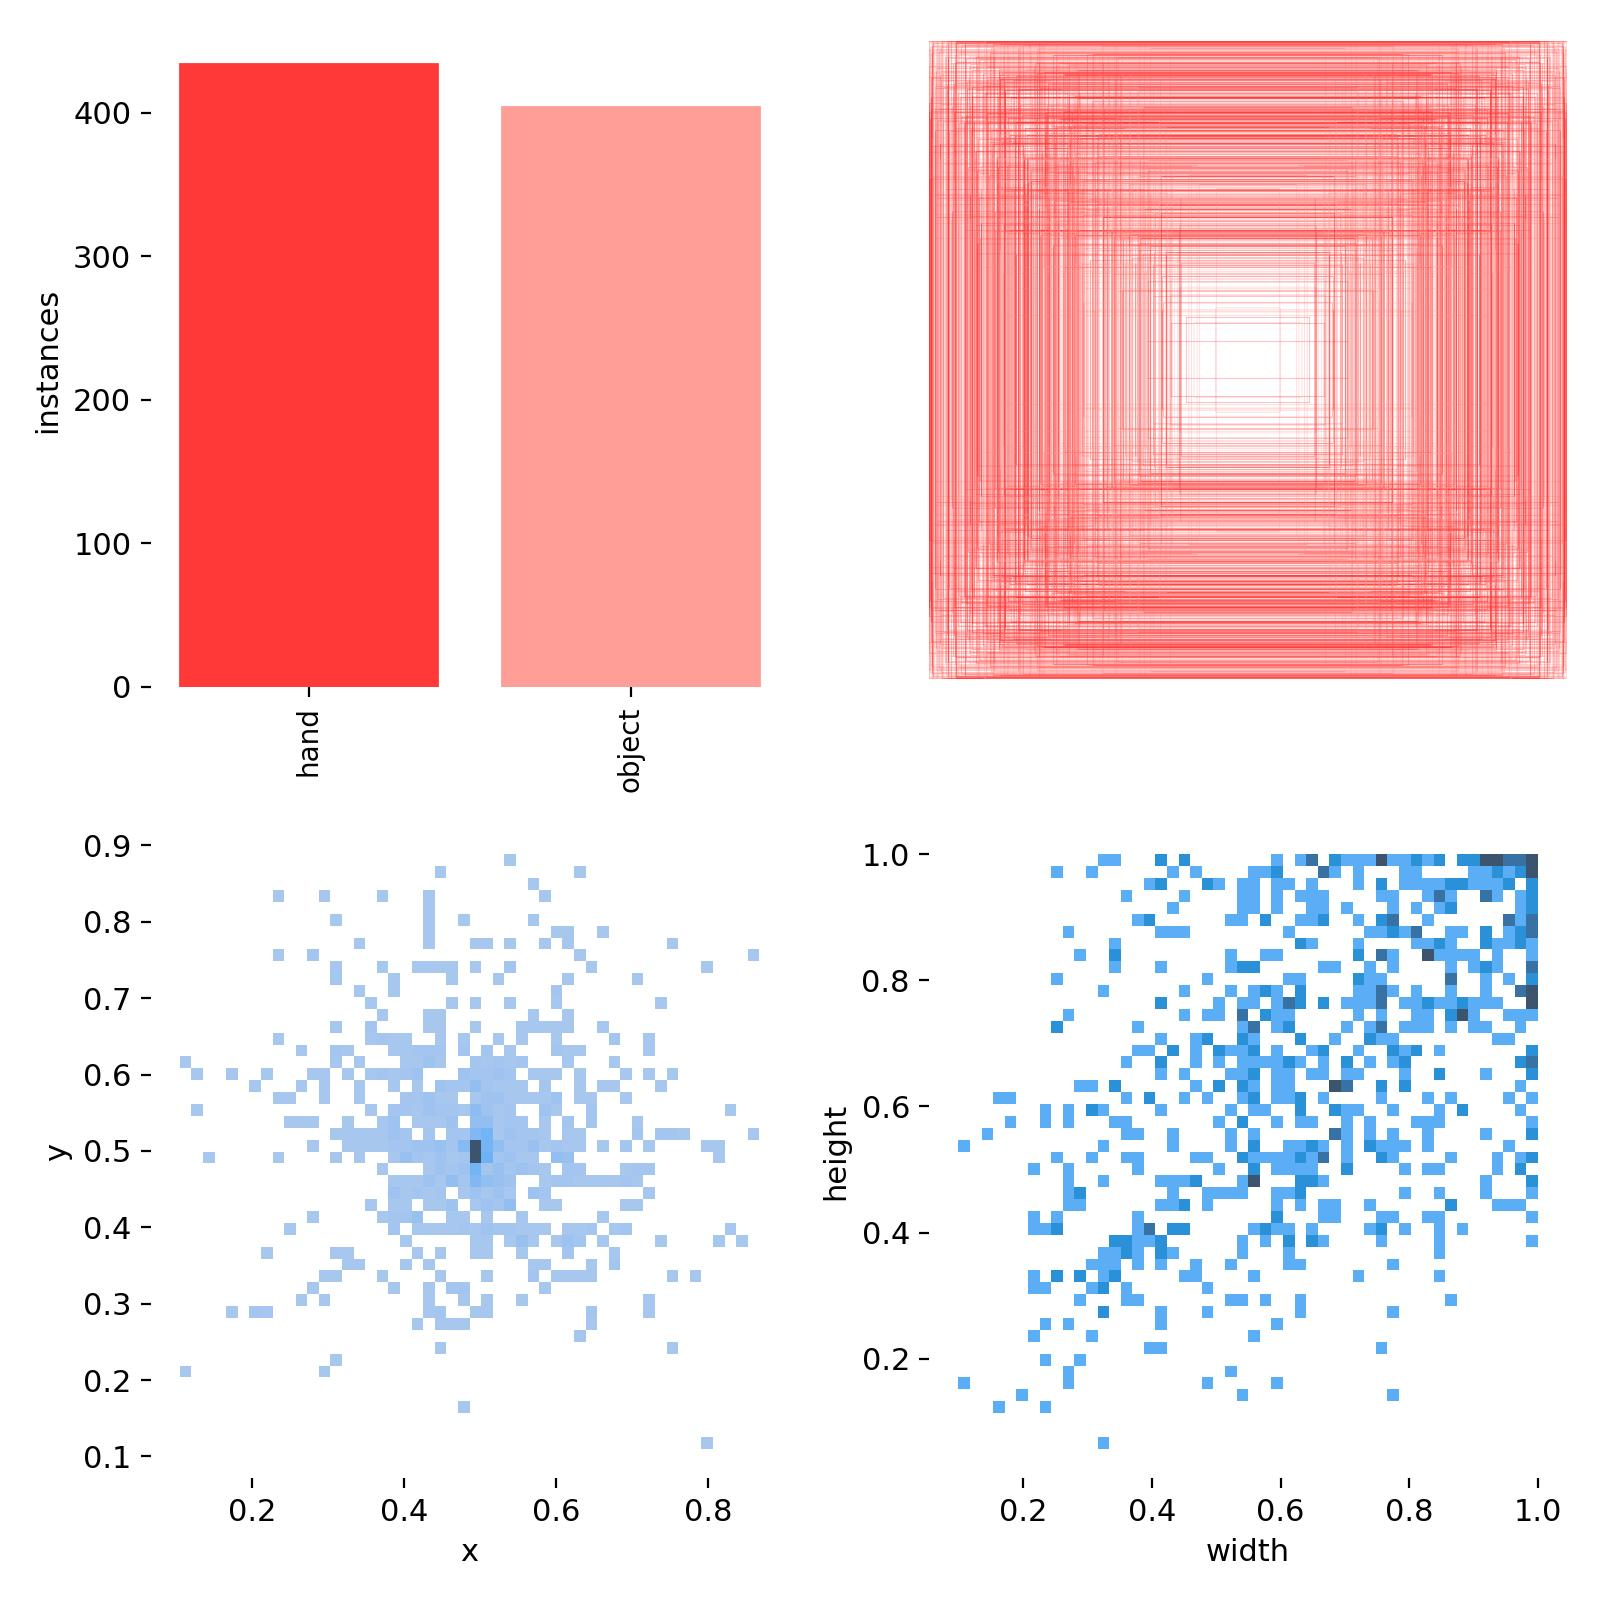

In [39]:
# Data label distribution
ip_display(Image(filename= ROOT + '/yolov5_resources/exp12/labels.jpg', width=640, height=640))

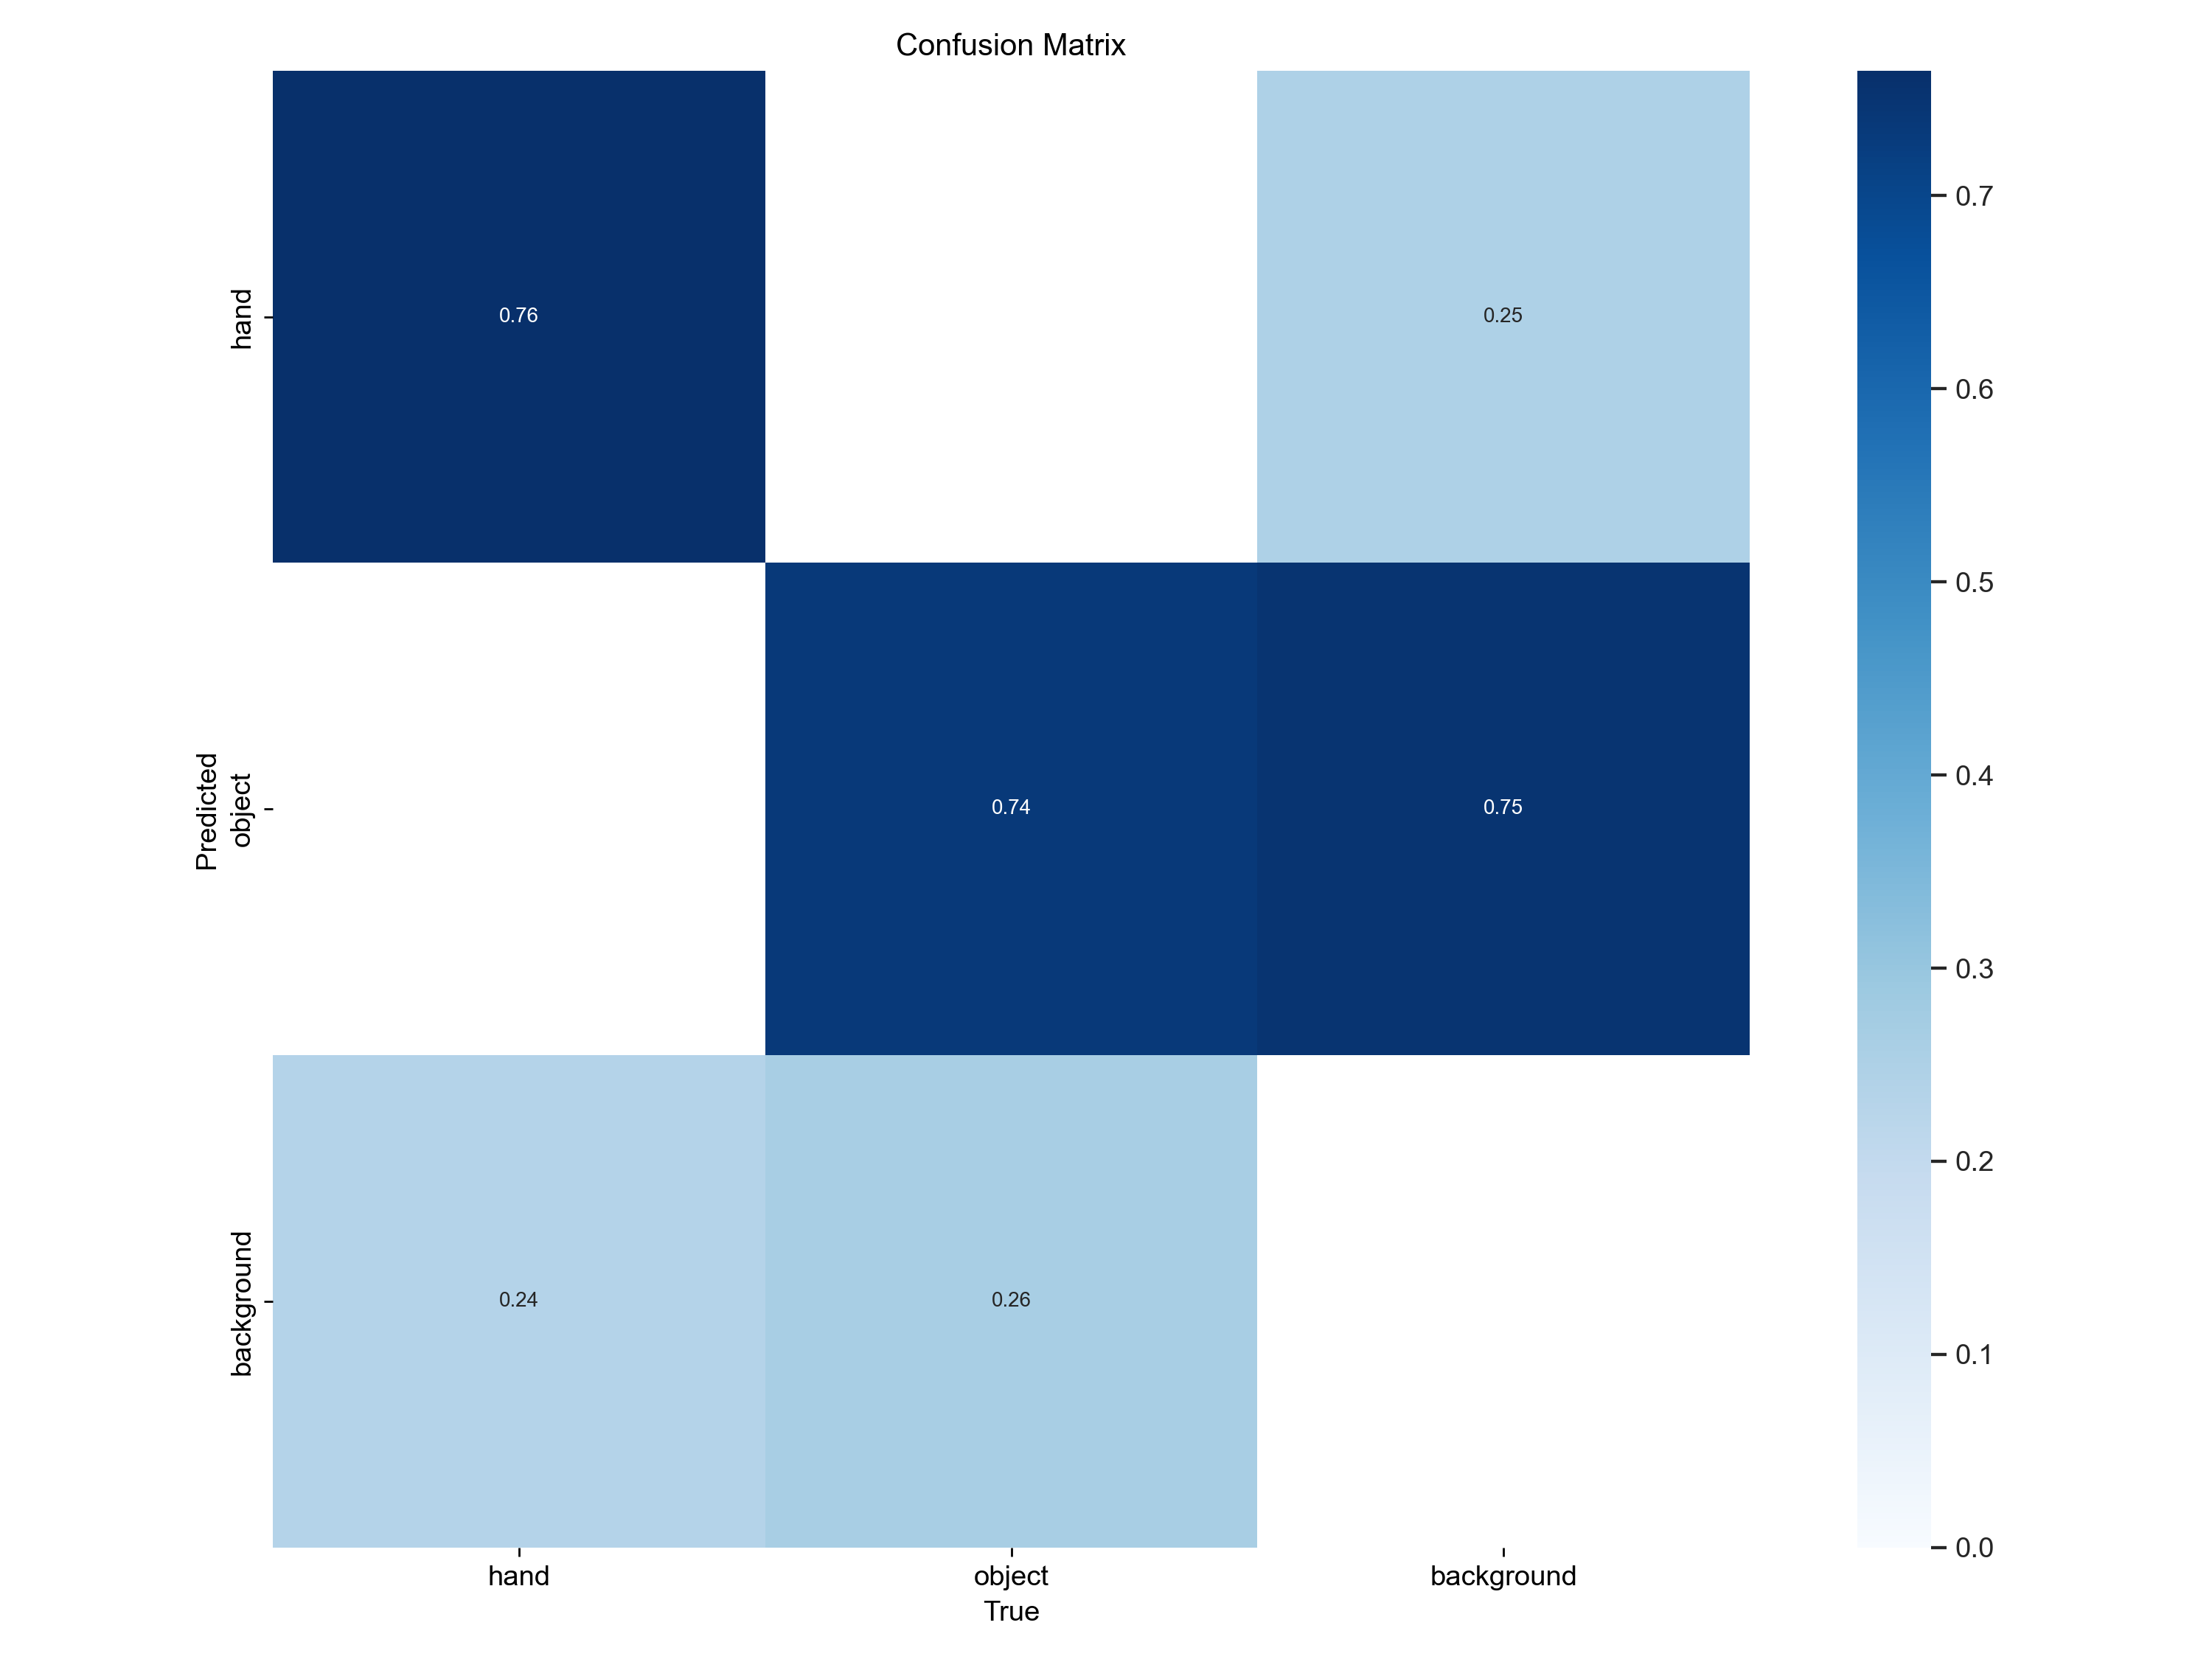

In [40]:
# Confusion matrix
ip_display(Image(filename= ROOT + '/yolov5_resources/exp12/confusion_matrix.png', width=640, height=640))

In [41]:
train_results = pd.read_csv(ROOT + "/yolov5_resources/exp12/results.csv", index_col=0)
train_results

,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,...,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
epoch,,,,,,,,,,,
0,0.084594,0.031127,0.025246,0.17527,0.11605,...,0.015717,0.023927,0.070769,0.003248,0.003248
1,0.055725,0.027490,0.020679,0.29621,0.44284,...,0.011741,0.021393,0.040606,0.006418,0.006418
2,0.053459,0.024085,0.016815,0.24814,0.33352,...,0.008298,0.018167,0.010278,0.009424,0.009424
3,0.050092,0.023421,0.014711,0.35665,0.41018,...,0.009653,0.022201,0.009258,0.009258,0.009258
4,0.046758,0.021892,0.011835,0.53010,0.58242,...,0.008803,0.008974,0.009258,0.009258,0.009258
5,0.044210,0.022782,0.014069,0.50189,0.47860,...,0.008100,0.007361,0.009010,0.009010,0.009010
6,0.040209,0.023568,0.012332,0.53081,0.56770,...,0.009572,0.010075,0.008762,0.008762,0.008762
7,0.040495,0.023051,0.014591,0.42589,0.50203,...,0.008774,0.017744,0.008515,0.008515,0.008515
8,0.039730,0.023093,0.011967,0.62528,0.54467,...,0.008334,0.008715,0.008268,0.008268,0.008268


**About the results**
- The model performs well on detecting hands. While on detecting object, its above average. 
- More images of objects will show an improvement on detecting the objects well. 
- Especially, those which are on the table/floor and singular.

**Future Improvements**:  
  - Train with larger, more diverse dataset  
  - Experiment with hyperparameter tuning  
  - Use YOLOv8 or newer architectures but as lightweight as yolov5s


## 6. References

- [YOLOv5 GitHub Repository](https://github.com/ultralytics/yolov5)  
- [Roboflow](https://roboflow.com)  
